In [35]:
import os
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from tqdm import tqdm
import librosa
import numpy as np
import miditoolkit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, average_precision_score, accuracy_score
import random
import pretty_midi

from symusic import Score
from miditok import REMI, TokenizerConfig
from midiutil import MIDIFile
from glob import glob
from collections import Counter
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import Audio


# used chatgpt to help me generate some functions

In [4]:
# Processing the midi files
midi_files = glob('nes_midis/*')
print(len(midi_files))

config = TokenizerConfig(num_velocities=1)
tokenizer = REMI(config)
tokenizer.train(vocab_size = 2000, files_paths=midi_files)


2000


In [14]:
instruments = {}
bad_files = []

for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        for instrument in midi.instruments:
            name = pretty_midi.program_to_instrument_name(instrument.program)
            instruments[name] = instruments.get(name, 0) + 1
    except Exception as e:
        bad_files.append(file)

#print(instruments)


<h1>Basic Exploratory Data Analysis

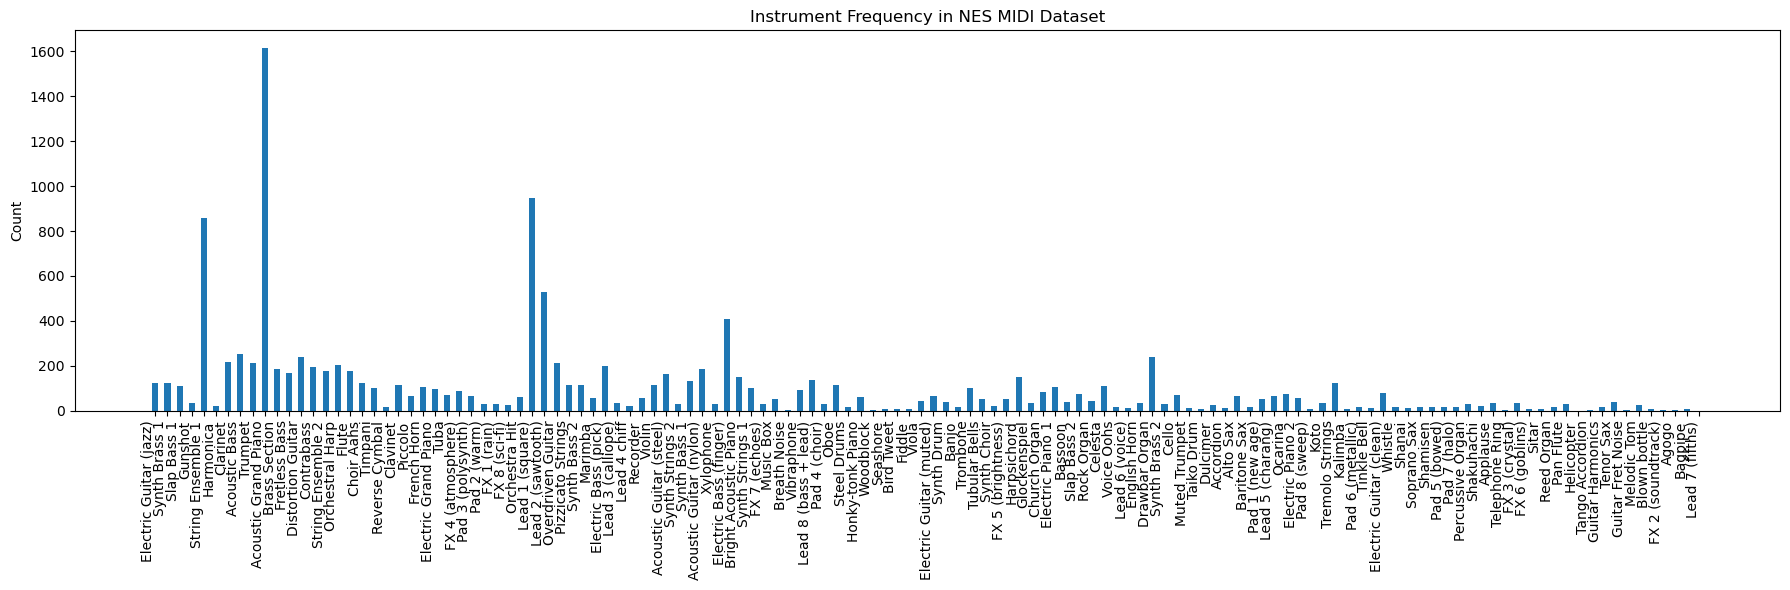

In [15]:
#Bar Graph showing total instrument count

names = list(instruments.keys())
counts = list(instruments.values())

plt.figure(figsize=(18, 6)) 
plt.bar(names, counts, width = .5)
plt.xticks(rotation=90, ha='right') 
plt.title("Instrument Frequency in NES MIDI Dataset")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

In [16]:
##Gives a note count per file and lists off the top 5 files with most notes
notes_per_file = []

for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        note_count = sum(len(instrument.notes) for instrument in midi.instruments)
        notes_per_file.append((file, note_count))
    except:
        continue

sorted(notes_per_file, key=lambda x: x[1], reverse=True)[:5]

[('nes_midis\\826_DoubleDragon-Stage1.mid', 35843),
 ('nes_midis\\1047_town4.mid', 23816),
 ('nes_midis\\1194_T_FinalFantasy_MatoyaTheme_ShiningRemix.mid', 20122),
 ('nes_midis\\723_contra.mid', 18274),
 ('nes_midis\\1016_dq4_fight.mid', 18146)]

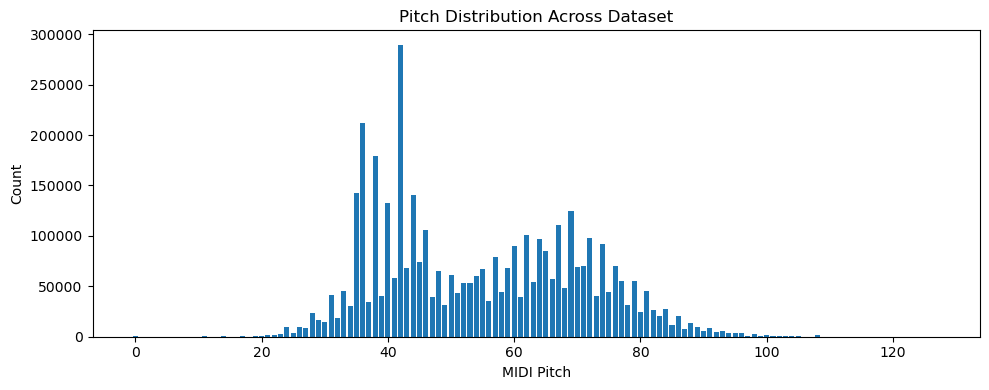

In [19]:
## Pitch Distribution Across Dataset

all_pitches = []
for file in midi_files:
    try:
        midi = pretty_midi.PrettyMIDI(file)
        for inst in midi.instruments:
            all_pitches.extend([note.pitch for note in inst.notes])
    except:
        continue

pitch_counts = Counter(all_pitches)

plt.figure(figsize=(10,4))
plt.bar(pitch_counts.keys(), pitch_counts.values())
plt.xlabel('MIDI Pitch')
plt.ylabel('Count')
plt.title('Pitch Distribution Across Dataset')
plt.tight_layout()
plt.show()

<h1> Baseline Model(s)

In [28]:
def note_extraction(midi_file):
    try:
        score = Score(midi_file)
    except Exception as e:
        print(f"Failed to parse {midi_file}: {e}")
        return []

    pitches = []
    for track in score.tracks:
        for note in track.notes:
            pitches.append(note.pitch)
    return pitches

In [29]:
#pairwise probabilities containing p(next_note | previous_note) values for the dataset
def note_bigram_probability(midi_files):
    bigramTransitions = defaultdict(list)
    bigramTransitionProbabilities = defaultdict(list)
    for file in midi_files:
        notes = note_extraction(file)
        for i in range(len(notes)-1):
            prev_note = notes[i]
            next_note = notes[i+1]
            bigramTransitions[prev_note].append(next_note)

    for prev_note,next_notes in bigramTransitions.items():
        total = len(next_notes)
        next_note_counts = defaultdict(int) ## dictionary to keep track of how many times a note comes after prev_note
        for note in next_notes:
            next_note_counts[note] += 1
        sorted_next_notes = list(next_note_counts.keys())
        probabilities = [next_note_counts[n] / total for n in sorted_next_notes]
        bigramTransitions[prev_note] = sorted_next_notes
        bigramTransitionProbabilities[prev_note] = probabilities
    return bigramTransitions, bigramTransitionProbabilities

In [38]:
## I believe we can calculate a perplexity score for transformers as well so we can compare perplexity scores as way of evaluation
def note_bigram_perplexity(midi_file):
    unigramProbabilities = note_unigram_probability(midi_files)
    bigramTransitions, bigramTransitionProbabilities = note_bigram_probability(midi_files)

    
    notes = note_extraction(midi_file)
    log_sum = 0

    first_note = notes[0]
    prob = unigramProbabilities.get(first_note, 1e-10)
    log_sum += np.log(prob)

    for i in range(1,len(notes)):
        prev_note = notes[i-1]
        current_note = notes[i]
        if prev_note in bigramTransitions:
            next_notes = bigramTransitions[prev_note]
            probs = bigramTransitionProbabilities[prev_note]
            if current_note in next_notes:
                index = next_notes.index(current_note)
                prob = probs[index]
        log_sum += np.log(prob)

    avg_log = log_sum / (len(notes))
    perplexity = np.exp(-avg_log)
    return perplexity

In [30]:
transitions, transition_probs = note_bigram_probability(midi_files)

Failed to parse nes_midis\1158_ff1fightgs1.mid: Get program=209
Failed to parse nes_midis\1171_ff1cast2.mid: Get control_value=255
Failed to parse nes_midis\1182_ff1gurgu.mid: Get control_value=255
Failed to parse nes_midis\1211_ff1ship3.mid: Get control_value=255
Failed to parse nes_midis\1245_ff2jbat3.mid: Get control_value=255
Failed to parse nes_midis\1258_ff2jfin2.mid: Get control_value=255
Failed to parse nes_midis\1808_vegetablevalley.mid: Get control_value=255
Failed to parse nes_midis\1934_ZeldaMelody.mid: Get program=255
Failed to parse nes_midis\837_DD.mid: Get program=255
Failed to parse nes_midis\951_Castle.mid: Get control_value=128
Failed to parse nes_midis\956_dw2town.mid: Get control_value=255


In [32]:
def generate_sequence(transitions, transition_probs, start_note, length=50):
    sequence = [start_note]
    current_note = start_note
    for _ in range(length - 1):
        if current_note not in transitions:
            break 
        next_notes = transitions[current_note]
        probs = transition_probs[current_note]
        next_note = random.choices(next_notes, weights=probs)[0]
        sequence.append(next_note)
        current_note = next_note
    return sequence

In [39]:
start_note = random.choice(list(transitions.keys()))
generated_notes = generate_sequence(transitions, transition_probs, start_note, length=100)

In [34]:
def notes_to_midi(note_sequence, filename="bigram_output.mid"):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=0)
    start = 0
    duration = 0.5  # constant duration
    for pitch in note_sequence:
        note = pretty_midi.Note(velocity=100, pitch=pitch, start=start, end=start+duration)
        instrument.notes.append(note)
        start += duration
    midi.instruments.append(instrument)
    midi.write(filename)

notes_to_midi(generated_notes)

Once the file is written above, you can have the music be played on this website:
https://pianotify.com/import-midi-file